# Imaging demonstration

### This script works through the high level arl interface to crocodile, making a fake data set and then deconvolving it. Finally the full and residual visibility are plotted.

In [1]:
%matplotlib inline

import sys, os
sys.path.append(os.path.join('..','..'))

from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord
from astropy import units as u
from astropy import constants as const

from matplotlib import pyplot as plt


from arl.image.deconvolution import deconvolve_cube
from arl.visibility.operations import create_visibility
from arl.skymodel.operations import create_skymodel_from_image, add_component_to_skymodel, create_skycomponent, \
    find_skycomponent
from arl.image.operations import show_image, import_image_from_fits, export_image_to_fits
from arl.util.testing_support import create_named_configuration, replicate_image, create_test_image
from arl.fourier_transforms.ftprocessor import predict_2d, invert_2d, create_image_from_visibility


import logging
log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

### Construct a VLA configuration and then shrink it to match our test image.

create_visibility: Created 22113 rows


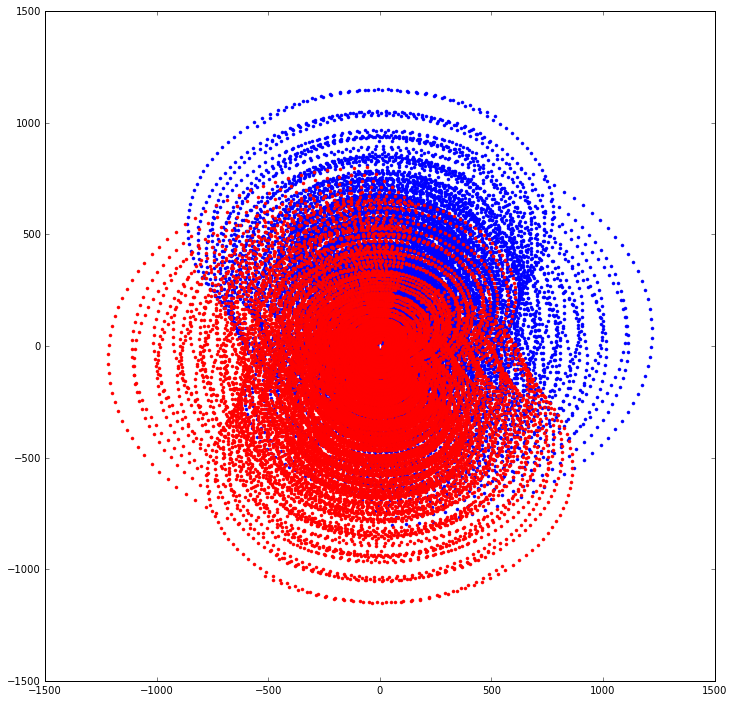

In [17]:
parameters = {}

vlaa = create_named_configuration('VLAA')
vlaa.data['xyz']=vlaa.data['xyz']/10.0


# We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

times = numpy.arange(-numpy.pi/2.0, +numpy.pi/2.0,0.05)
frequency = numpy.array([1e8])

reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(0.0*u.rad, u.rad*numpy.pi/4, frame='icrs', equinox=2000.0)
vt = create_visibility(vlaa, times, frequency, weight=1.0, phasecentre=phasecentre)


# Plot the synthesized uv coverage, including for MFS

plt.clf()
for f in frequency:
    x=f/const.c
    plt.plot(x*vt.data['uvw'][:,0], x*vt.data['uvw'][:,1], '.', color='b')
    plt.plot(-x*vt.data['uvw'][:,0], -x*vt.data['uvw'][:,1], '.', color='r')

### Read the venerable test image, constructing an image

In [21]:
parameters={}
parameters['npixel']=512
parameters['cellsize']=0.0001
parameters['wstep']=30.0

m31image = create_test_image(npol=4, nchan=len(frequency), cellsize=parameters['cellsize'])
fig=show_image(m31image)

import_image_from_fits: Max, min in /Users/timcornwell/Code/crocodile/data/models/M31.MOD = 1.006458, 0.000000
replicate_image: replicating shape (256, 256) to (1, 4, 256, 256)


ftprocessor.predict_2d: predicting using PSWF


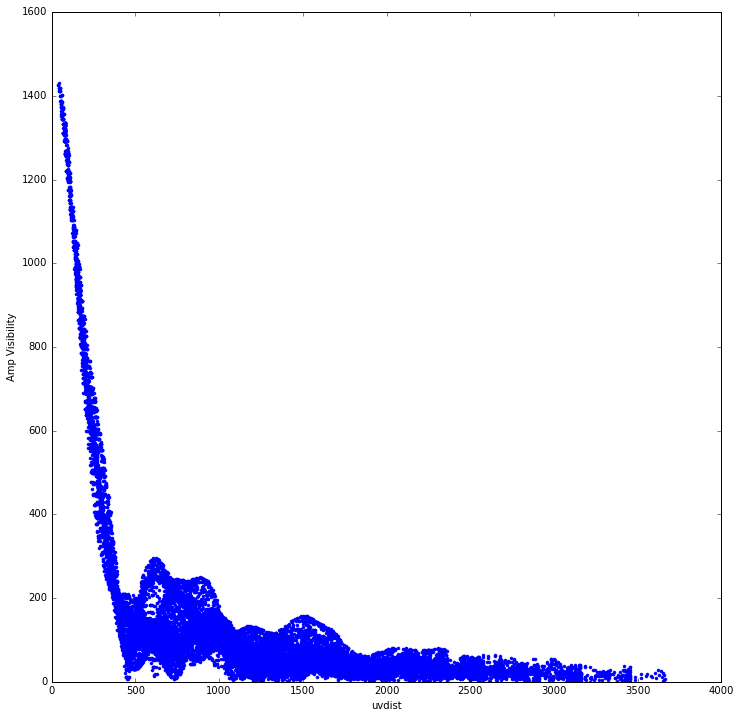

In [22]:
vt = predict_2d(vt, m31image, params=parameters)

# To check that we got the prediction right, plot the amplitude of the visibility.
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]), '.')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()

### Make the dirty image and point spread function

fourier_transforms.create_wcs_from_visibility: Parsing parameters to get definition of WCS
fourier_transforms.create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (0.0, 45.0)>, frequency 100000000.0 Hz, and bandwidth 100000000.0 Hz
create_wcs_from_visibility: uvmax = 1218.434867 lambda
create_wcs_from_visibility: Critical cellsize = 0.000410 radians, 0.023512 degrees
create_wcs_from_visibility: Cellsize          = 0.000100 radians, 0.005730 degrees
ftprocessor.invert_2d: inverting using PSWF
ftprocessor.invert_2d: inverting using PSWF
Max, min in dirty image = 114.555071, -8.038006, psfmax = 0.085241
Max, min in PSF         = 1.000000, -0.017726, psfmax = 0.085241


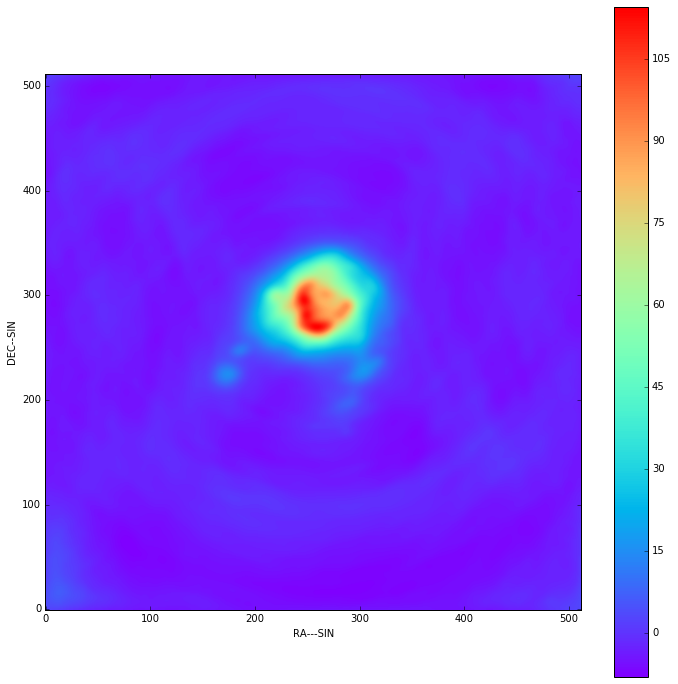

In [23]:
model = create_image_from_visibility(vt, params=parameters)
dirty = invert_2d(vt, model, params=parameters)
psf = invert_2d(vt, model, dopsf=True, params=parameters)
psfmax = psf.data.max()
dirty.data = dirty.data/psfmax
psf.data = psf.data/psfmax

show_image(dirty)
print("Max, min in dirty image = %.6f, %.6f, psfmax = %f" % (dirty.data.max(), dirty.data.min(), psfmax))

print("Max, min in PSF         = %.6f, %.6f, psfmax = %f" % (psf.data.max(), psf.data.min(), psfmax))

export_image_to_fits(dirty, 'imaging_dirty.fits')
export_image_to_fits(psf, 'imaging_psf.fits')

### Deconvolve using clean

log_parameters:   fracthresh      =       0.01
log_parameters:   threshold      =       0.001
log_parameters:   niter      =       100
deconvolve_cube: Processing pol 0, channel 0
msclean: Peak of PSF = 1.0 at (256, 256)
msclean: Peak of Dirty = 114.555071421 at (270, 258)
msclean: Coupling matrix =
 [[ 1.          0.99453243  0.91807245  0.56853436]
 [ 0.99453243  0.98913084  0.91356421  0.56716255]
 [ 0.91807245  0.91356421  0.85012711  0.54719332]
 [ 0.56853436  0.56716255  0.54719332  0.42552059]]
msclean: Max abs in dirty Image = 114.555071
msclean: Start of minor cycle
msclean: This minor cycle will stop at 100 iterations or peak < 1.14555071421
msclean: Minor cycle 0, peak [ 110.07100094  110.05729985  109.82556455  106.65705343] at [273, 255, 3]
msclean: Minor cycle 10, peak [ 21.40452779  21.40576333  21.41025974  20.69413589] at [301, 293, 3]
msclean: Minor cycle 20, peak [ 16.50140396  16.47825465  16.1403311   14.01338009] at [309, 311, 3]
msclean: Minor cycle 30, peak [-17

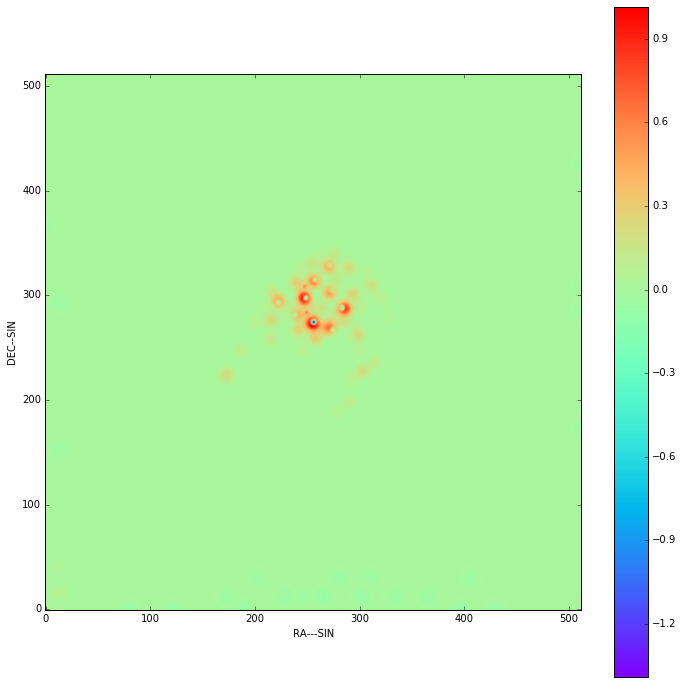

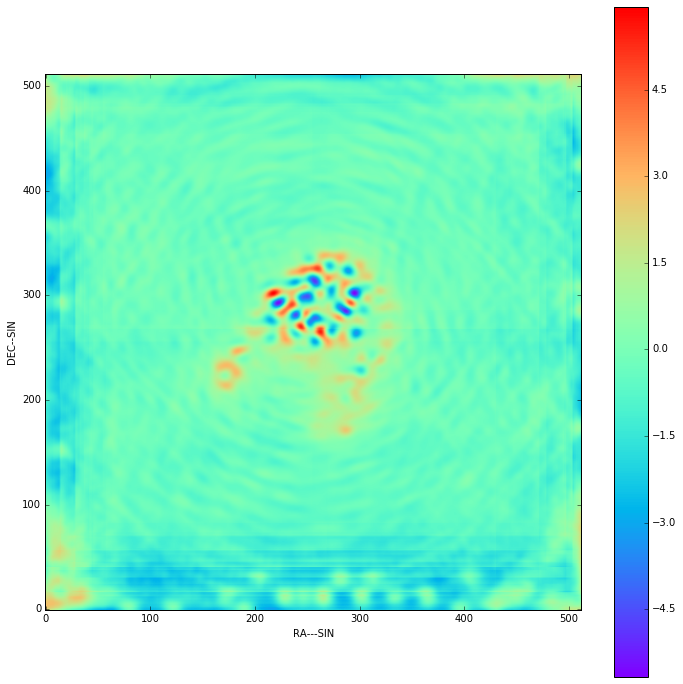

In [24]:
parameters={'niter':100, 'threshold':0.001, 'fracthresh':0.01}
comp, residual = deconvolve_cube(dirty, psf, parameters)

# Show the results

fig=show_image(comp)
fig=show_image(residual)

### Predict the visibility of the model

In [25]:
vtmodel = create_visibility(vlaa, times, frequency, weight=1.0, phasecentre=phasecentre)
vtmodel=predict_2d(vtmodel, comp, params=parameters)

create_visibility: Created 22113 rows
ftprocessor.predict_2d: predicting using PSWF


# Now we will plot the original visibility and the residual visibility.

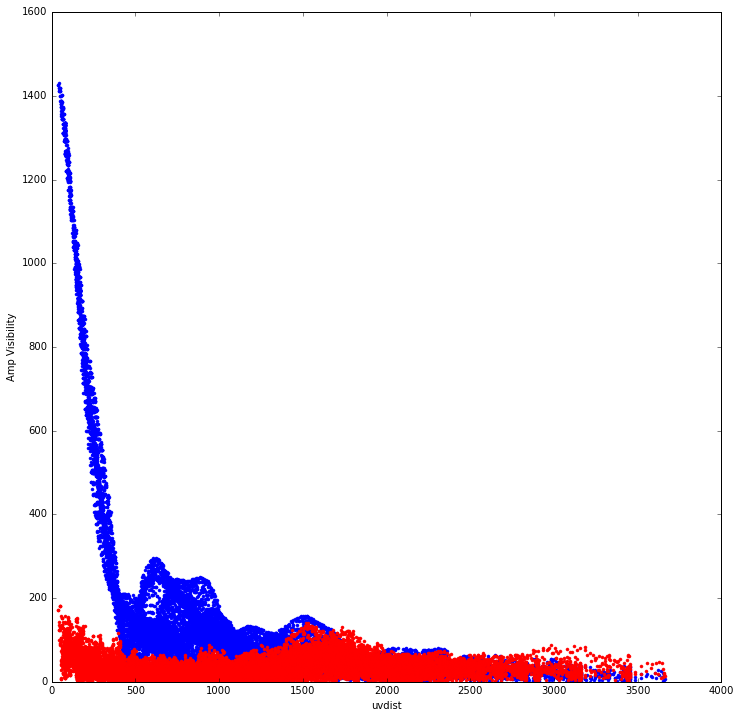

In [26]:
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]), '.', color='b')
plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]-vtmodel.data['vis'][:,0,0]), '.', color='r')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()